## Imports

In [4]:
import tensorflow as tf

import timeit
import pandas as pd
import numpy as np
import math

import os
import platform

import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras import models
from keras import optimizers

## Preprocessing / loading data

In [5]:
def Load_and_extractCifar():
    """ load all of cifar in the required directory format for train, test, and val"""

    !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    
    !tar -xvf  '/content/cifar-10-python.tar.gz'

    img_rows = img_cols = 32

    # data is stored at '/content/cifar-10-batches-py/data_batch_x' where x is from 1-5
    # there is also a 'test-batch' for testing data

    img_rows=img_cols=32
    x_arr = []
    y_arr = []
    x = range(1,6)
    for el in x:
        filename=f'/content/cifar-10-batches-py/data_batch_{el}'
        with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='latin1')
            X = datadict['data']
            Y = datadict['labels']
            x_arr.append(X.reshape(10000,img_rows, img_cols,3))
            y_arr.append(np.array(Y))
        
    X_train = np.concatenate(x_arr) # (50,000, 32, 32, 3)
    y_train = np.concatenate(y_arr) # (50,000, 32, 32, 3)

    x_arr = []
    y_arr = []
    test_fname = '/content/cifar-10-batches-py/test_batch'
    with open(test_fname, 'rb') as f:
            datadict = pickle.load(f, encoding='latin1')
            X = datadict['data']
            Y = datadict['labels']
            x_arr.append(X.reshape(10000,img_rows, img_cols,3))
            y_arr.append(np.array(Y))
            
    X_test = np.concatenate(x_arr) # (10,000, 32, 32, 3)
    y_test = np.concatenate(y_arr) # (10,000, 32, 32, 3)

    # Now we have X_train, y_train, X_test, y_test  

    # Let's take 5000 from the training set and 2500 from the test set to 
    # make a validation set of 7500
    # That'll leave our final split with 45000 train, 7500 val, 7500 test --> 75, 12.5, 12.5 split

    #We can take the last 5000 from the training set
    last_5000x = X_train[-5000:]
    last_5000y = y_train[-5000:]

    X_train = X_train[0:45000]
    y_train = y_train[0:45000]
    
    last_2500x = X_test[-2500:]
    last_2500y = y_test[-2500:]

    X_test = X_test[0:7500]
    y_test = y_test[0:7500]
    
    X_val = np.concatenate((last_5000x, last_2500x))
    y_val = np.concatenate((last_5000y, last_2500y))

    #additional pre-processing
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')
   
    X_train /= 255.
    X_val /= 255.
    X_test /= 255.

    y_val = tf.keras.utils.to_categorical(y_val)
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    # removing useless files
    !rm /content/cifar-10-python.tar.gz

    return X_train, y_train, X_test, y_test, X_val, y_val



In [6]:
X_train, y_train, X_test, y_test, X_val, y_val = Load_and_extractCifar()

--2022-11-11 21:18:38--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  67.8MB/s    in 2.4s    

2022-11-11 21:18:41 (67.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 10)
X_test shape: (7500, 32, 32, 3)
y_test shape: (7500, 10)
X_val shape: (7500, 32, 32, 3)
y_val shape: (7500, 10)


## Model development

In [8]:
# plotting function:
def generate_plots(history):
    #accuracies
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def model_init():
    img_dim = 32
    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu', input_shape=(img_dim, img_dim, 3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))

    model.add(layers.Dense(units=10, activation='softmax'))

    return model



In [ ]:
model = model_init()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

In [ ]:
# Compile the model and train
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=["acc"])
BATCH_SIZE = 256
EPOCHS = 10
history = model.fit(ImageDataGenerator().flow(X_train,y_train,batch_size = BATCH_SIZE),
                             validation_data = (X_val, y_val),
                             epochs=EPOCHS,
                             steps_per_epoch= len(X_train)//BATCH_SIZE,
                             workers=10,
                             use_multiprocessing=True)

Epoch 1/10
175/175 [==============================] - 14s 28ms/step - loss: 1.7312 - acc: 0.3675 - val_loss: 2.0999 - val_acc: 0.2577
Epoch 2/10
175/175 [==============================] - 5s 25ms/step - loss: 1.3889 - acc: 0.5010 - val_loss: 1.6352 - val_acc: 0.5029
Epoch 3/10
175/175 [==============================] - 5s 25ms/step - loss: 1.2383 - acc: 0.5553 - val_loss: 1.8822 - val_acc: 0.3585
Epoch 4/10
175/175 [==============================] - 5s 25ms/step - loss: 1.1408 - acc: 0.5938 - val_loss: 1.2305 - val_acc: 0.5603
Epoch 5/10
175/175 [==============================] - 5s 25ms/step - loss: 1.0622 - acc: 0.6222 - val_loss: 1.2253 - val_acc: 0.5595
Epoch 6/10
175/175 [==============================] - 5s 25ms/step - loss: 0.9957 - acc: 0.6472 - val_loss: 1.1702 - val_acc: 0.5860
Epoch 7/10
175/175 [==============================] - 5s 24ms/step - loss: 0.9379 - acc: 0.6669 - val_loss: 1.3579 - val_acc: 0.5552
Epoch 8/10
175/175 [==============================] - 8s 39ms/step -

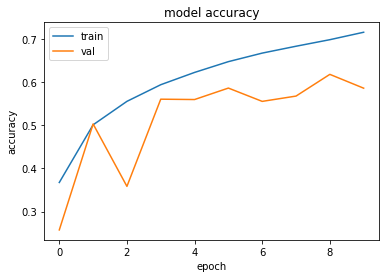

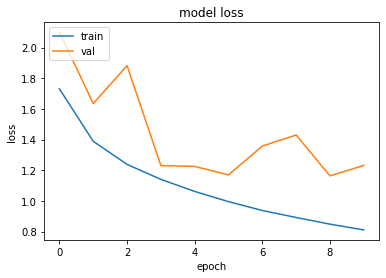

In [ ]:
generate_plots(history)

The model overfits. Let's first evaluate the performance of the model after combining training and val data. Tweaking the LR, and only training for like 6 epochs.

In [ ]:
# re-initiating the model
model = model_init()
# Compile the model and train
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.00085), #reduced LR
              metrics=["acc"])
BATCH_SIZE = 256
EPOCHS = 7 # arbitrary, just increased this because i added in early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1) #added early stopping
history = model.fit(ImageDataGenerator().flow(
    np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), batch_size = BATCH_SIZE
    ),
                            #  validation_data = (X_val, y_val),
                            epochs=EPOCHS,
                            steps_per_epoch= len(X_train)//BATCH_SIZE,
                            workers=10,
                            use_multiprocessing=True,
                            callbacks=[callback])
                             

# evalaute the model performance now
res = model.evaluate(X_test,y_test)
print(f'Model loss: {res[0]}\nModel accuracy: {res[1]}')

Epoch 1/7
175/175 [==============================] - 5s 22ms/step - loss: 1.7092 - acc: 0.3800
Epoch 2/7
175/175 [==============================] - 5s 22ms/step - loss: 1.3932 - acc: 0.4975
Epoch 3/7
175/175 [==============================] - 5s 22ms/step - loss: 1.2482 - acc: 0.5550
Epoch 4/7
175/175 [==============================] - 5s 22ms/step - loss: 1.1579 - acc: 0.5873
Epoch 5/7
175/175 [==============================] - 5s 22ms/step - loss: 1.0834 - acc: 0.6143
Epoch 6/7
175/175 [==============================] - 5s 22ms/step - loss: 1.0221 - acc: 0.6374
Epoch 7/7
235/235 [==============================] - 1s 3ms/step - loss: 1.1369 - acc: 0.6007
Model loss: 1.136894702911377
Model accuracy: 0.6006666421890259


~60.1% accuracy after tuning a few parameters and re-training on all training and validation data and evaluating on test set.

Let's add an inception block and evaluate the performance

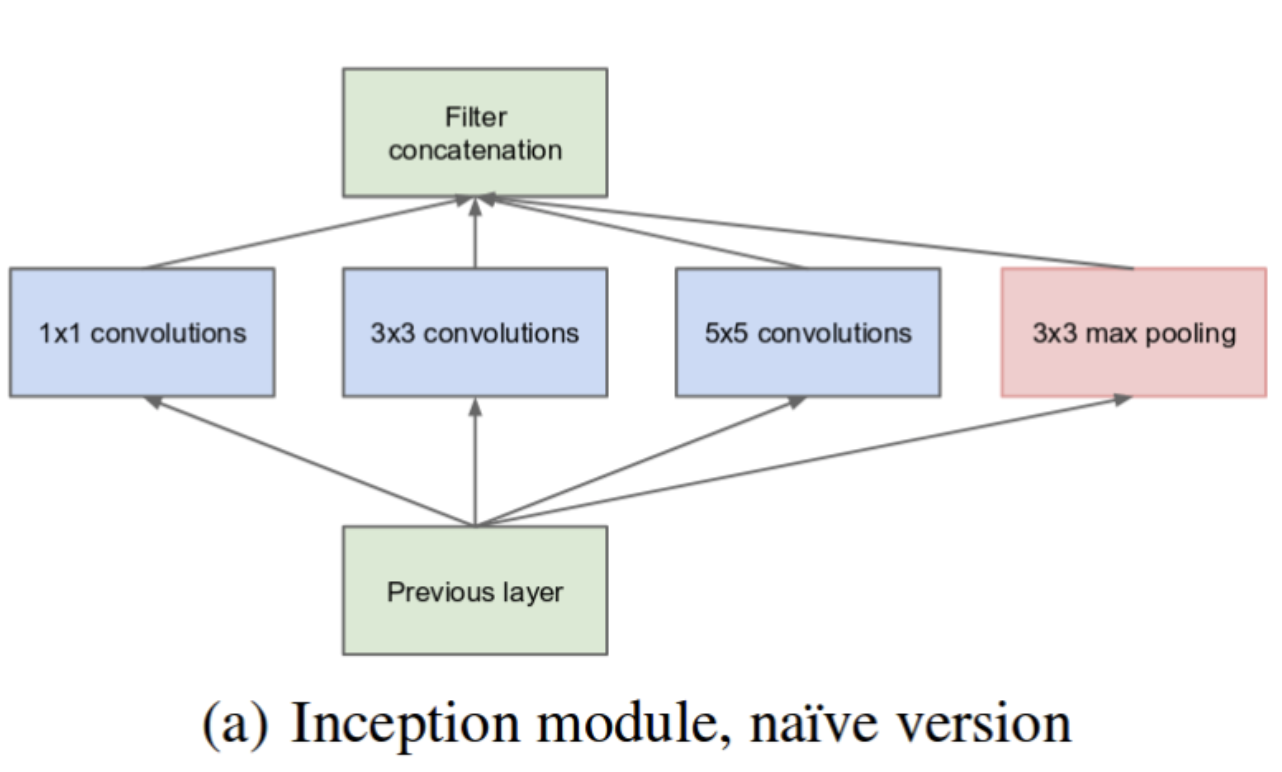

In [ ]:
from IPython import display
display.Image('/content/Screenshot 2022-11-11 at 11.41.33 AM.png')

In [14]:
def model_inception():
    '''creates a model with inception block'''

    def naive_inception_block(input):
        block1 = layers.Conv2D(64, (1,1), padding='same', activation='relu')(input)
        block2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input)
        block3 = layers.Conv2D(64, (5,5), padding='same', activation='relu')(input)
        block4 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
        block = layers.concatenate([block1, block2, block3, block4], axis = 3)
        return block

    img_dim = 32
    img_inputs = tf.keras.Input(shape=(img_dim, img_dim, 3))

    x = layers.Conv2D(32, (3,3), padding='same',activation='relu', input_shape=(32, 32, 3))(img_inputs)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(rate=0.15)(x)

    inception = naive_inception_block(x)

    x = layers.Conv2D(128,  (3,3), padding='same', activation='relu')(inception)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(rate=0.10)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(rate=0.15)(x)
    outputs = layers.Dense(units=10, activation='softmax')(x)
    
    return tf.keras.Model(inputs=img_inputs,outputs=outputs)

In [15]:
model_inceptionblock = model_inception()
model_inceptionblock.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 32)  0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 64)   18496       ['max_pooling2d_6[0][0]']        
                                                                                            

In [16]:
# Compile the model and train
model_inceptionblock.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=["acc"])
BATCH_SIZE = 256
EPOCHS = 15
# CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1) #added early stopping
history_inception = model_inceptionblock.fit(ImageDataGenerator().flow(X_train,y_train,batch_size = BATCH_SIZE),
                             validation_data = (X_val, y_val),
                             epochs=EPOCHS,
                             steps_per_epoch= len(X_train)//BATCH_SIZE,
                             workers=10,
                             use_multiprocessing=True)
                            #  callbacks = [CALLBACK])

Epoch 1/15
175/175 [==============================] - 8s 34ms/step - loss: 1.8582 - acc: 0.3341 - val_loss: 2.0374 - val_acc: 0.4120
Epoch 2/15
175/175 [==============================] - 6s 32ms/step - loss: 1.4527 - acc: 0.4778 - val_loss: 1.6648 - val_acc: 0.4780
Epoch 3/15
175/175 [==============================] - 6s 32ms/step - loss: 1.2929 - acc: 0.5377 - val_loss: 1.3361 - val_acc: 0.5313
Epoch 4/15
175/175 [==============================] - 6s 29ms/step - loss: 1.2015 - acc: 0.5739 - val_loss: 1.3050 - val_acc: 0.5391
Epoch 5/15
175/175 [==============================] - 8s 41ms/step - loss: 1.1208 - acc: 0.6017 - val_loss: 1.1593 - val_acc: 0.5920
Epoch 6/15
175/175 [==============================] - 6s 28ms/step - loss: 1.0653 - acc: 0.6215 - val_loss: 1.0960 - val_acc: 0.6149
Epoch 7/15
175/175 [==============================] - 6s 32ms/step - loss: 1.0136 - acc: 0.6394 - val_loss: 1.0957 - val_acc: 0.6135
Epoch 8/15
175/175 [==============================] - 6s 29ms/step - 

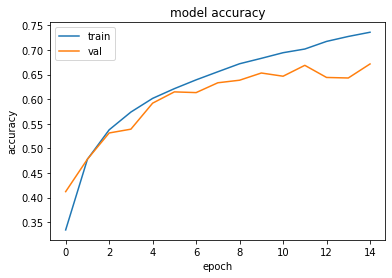

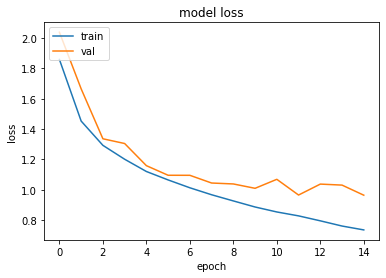

In [17]:
generate_plots(history_inception)

Re-training with all data and evaluating performance as a benchmark before hyperparameter tuning

In [19]:
# Compile the model and train
model_inceptionblock.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=["acc"])
BATCH_SIZE = 256
EPOCHS = 12 # decreased epochs
# CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1) #added early stopping
history_inception = model_inceptionblock.fit(ImageDataGenerator().flow(
    np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)), batch_size = BATCH_SIZE),
                            #  validation_data = (X_val, y_val),
                             epochs=EPOCHS,
                             steps_per_epoch= len(X_train)//BATCH_SIZE,
                             workers=10,
                             use_multiprocessing=True)
                            #  callbacks = [CALLBACK])

# evalaute the model performance now
res = model_inceptionblock.evaluate(X_test,y_test)
print(f'Inception block model loss: {res[0]}\nInception block model accuracy: {res[1]}')

Epoch 1/12
175/175 [==============================] - 8s 30ms/step - loss: 0.5305 - acc: 0.8076
Epoch 2/12
175/175 [==============================] - 5s 25ms/step - loss: 0.5093 - acc: 0.8161
Epoch 3/12
175/175 [==============================] - 5s 25ms/step - loss: 0.4967 - acc: 0.8210
Epoch 4/12
175/175 [==============================] - 5s 26ms/step - loss: 0.4972 - acc: 0.8204
Epoch 5/12
175/175 [==============================] - 5s 25ms/step - loss: 0.4874 - acc: 0.8232
Epoch 6/12
175/175 [==============================] - 5s 25ms/step - loss: 0.4702 - acc: 0.8316
Epoch 7/12
175/175 [==============================] - 5s 25ms/step - loss: 0.4714 - acc: 0.8294
Epoch 8/12
175/175 [==============================] - 5s 25ms/step - loss: 0.4639 - acc: 0.8338
Epoch 9/12
175/175 [==============================] - 6s 31ms/step - loss: 0.4676 - acc: 0.8306
Epoch 10/12
175/175 [==============================] - 5s 25ms/step - loss: 0.4439 - acc: 0.8376
Epoch 11/12
175/175 [==================

~67.3% accuracy, a good improvement from before with the inclusion of the inception block

In [20]:
model_inceptionblock.save('model_inceptionblock.h5')

Residual blocks

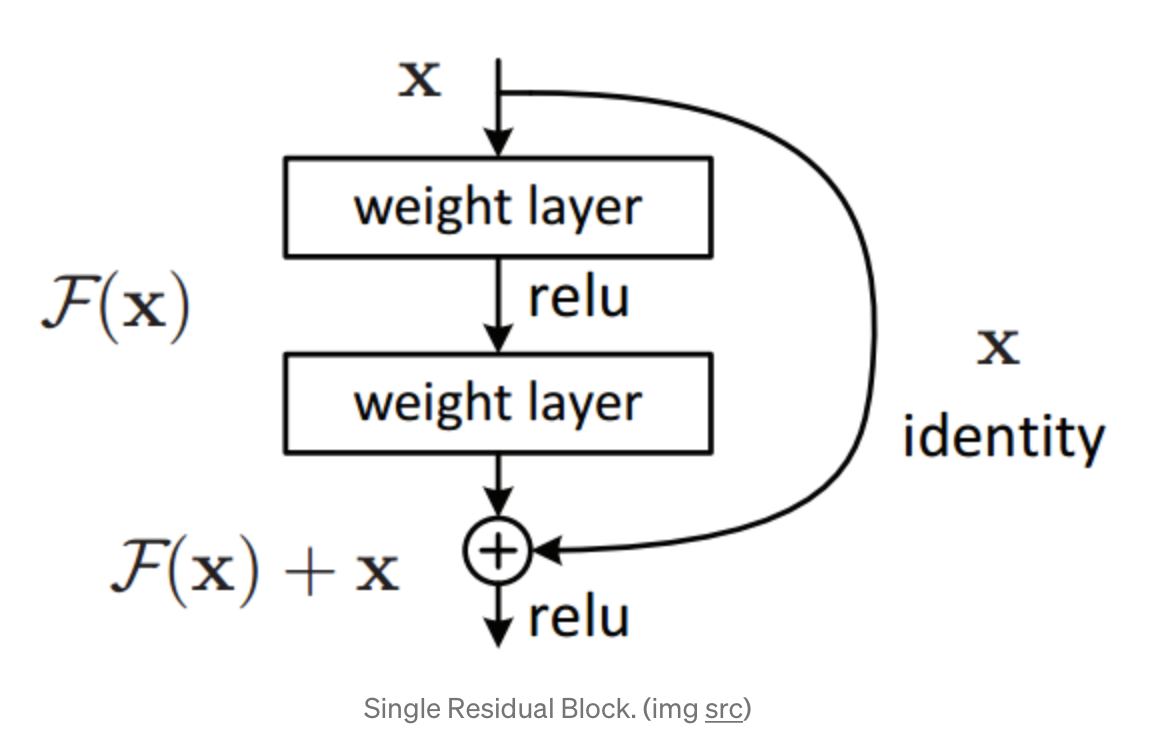

In [ ]:
from IPython import display
display.Image('/content/Screenshot 2022-11-11 at 2.25.14 PM.png')

In [9]:
def model_residual():
    '''creates a model with residual block'''

    img_dim = 32
    img_inputs = tf.keras.Input(shape=(img_dim, img_dim, 3))

    x = layers.Conv2D(32, (3,3), padding='same',activation='relu', input_shape=(32, 32, 3))(img_inputs)
    x = layers.MaxPooling2D(2,2)(x)

    x_1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.MaxPooling2D(2,2)(x_1)
    x_1 = layers.Dropout(rate=0.15)(x_1)
    
    x_2 = layers.Conv2D(64,  (3,3), padding='same', activation='relu')(x_1)
    x_2 = layers.BatchNormalization()(x_2)
    # x_2 = layers.MaxPooling2D(2,2)(x_2) #<--- cant have this pooling since it'll change the dimensions and we wnt be able to add
    x_2 = layers.Dropout(rate=0.10)(x_2)

    res_conn = layers.Add()([x_1,x_2]) # skip connection
    x = layers.Flatten()(res_conn)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(rate=0.15)(x)
    outputs = layers.Dense(units=10, activation='softmax')(x)
    
    return tf.keras.Model(inputs=img_inputs,outputs=outputs)

In [10]:
model_residualconn = model_residual()
model_residualconn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

Epoch 1/15
175/175 [==============================] - 13s 26ms/step - loss: 1.6877 - acc: 0.4197 - val_loss: 4.5220 - val_acc: 0.1837
Epoch 2/15
175/175 [==============================] - 5s 27ms/step - loss: 1.2841 - acc: 0.5440 - val_loss: 3.1972 - val_acc: 0.2627
Epoch 3/15
175/175 [==============================] - 5s 25ms/step - loss: 1.1360 - acc: 0.5984 - val_loss: 1.4837 - val_acc: 0.5044
Epoch 4/15
175/175 [==============================] - 5s 25ms/step - loss: 1.0234 - acc: 0.6387 - val_loss: 1.2647 - val_acc: 0.5707
Epoch 5/15
175/175 [==============================] - 5s 24ms/step - loss: 0.9292 - acc: 0.6700 - val_loss: 1.1889 - val_acc: 0.5893
Epoch 6/15
175/175 [==============================] - 5s 24ms/step - loss: 0.8459 - acc: 0.6988 - val_loss: 1.6899 - val_acc: 0.5303
Epoch 7/15
175/175 [==============================] - 5s 24ms/step - loss: 0.7550 - acc: 0.7315 - val_loss: 1.0561 - val_acc: 0.6460
Epoch 8/15
175/175 [==============================] - 5s 24ms/step -

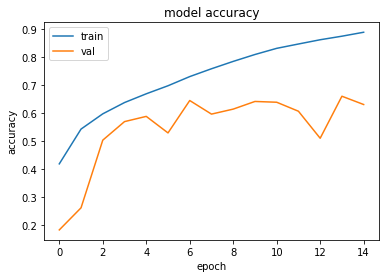

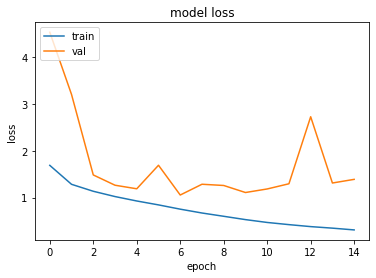

235/235 [==============================] - 1s 3ms/step - loss: 1.4406 - acc: 0.6283
Residual model loss: 1.4406160116195679
Residual model accuracy: 0.6282666921615601


In [11]:
model_residualconn = model_residual()

# Compile the model and train
model_residualconn.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=["acc"])
BATCH_SIZE = 256
EPOCHS = 15
# CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1) #added early stopping
history_resid = model_residualconn.fit(ImageDataGenerator().flow(X_train,y_train,batch_size = BATCH_SIZE),
                             validation_data = (X_val, y_val),
                             epochs=EPOCHS,
                             steps_per_epoch= len(X_train)//BATCH_SIZE,
                             workers=10,
                             use_multiprocessing=True)
                            #  callbacks = [CALLBACK])

# results
generate_plots(history_resid)
# evalaute the model performance now
res = model_residualconn.evaluate(X_test,y_test)
print(f'Residual model loss: {res[0]}\nResidual model accuracy: {res[1]}')


Let's tune the params slightly, combine the training and val data and evaluate performance

In [12]:
model_residualconn = model_residual()

# Compile the model and train
model_residualconn.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=["acc"])

BATCH_SIZE = 256
EPOCHS = 10 # reduced epochs

# CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1) #added early stopping
history_resid = model_residualconn.fit(ImageDataGenerator().flow(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), batch_size = BATCH_SIZE),
                            #  validation_data = (X_val, y_val),
                             epochs=EPOCHS,
                             steps_per_epoch= len(X_train)//BATCH_SIZE,
                             workers=10,
                             use_multiprocessing=True)
                            #  callbacks = [CALLBACK])

# results
# generate_plots(history_resid)

# evalaute the model performance now
res = model_residualconn.evaluate(X_test,y_test)
print(f'Residual model loss: {res[0]}\nResidual model accuracy: {res[1]}')


Epoch 1/10
175/175 [==============================] - 5s 24ms/step - loss: 1.7476 - acc: 0.4076
Epoch 2/10
175/175 [==============================] - 5s 22ms/step - loss: 1.3136 - acc: 0.5322
Epoch 3/10
175/175 [==============================] - 4s 22ms/step - loss: 1.1582 - acc: 0.5887
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 1.0502 - acc: 0.6252
Epoch 5/10
175/175 [==============================] - 5s 23ms/step - loss: 0.9739 - acc: 0.6543
Epoch 6/10
175/175 [==============================] - 5s 25ms/step - loss: 0.8867 - acc: 0.6831
Epoch 7/10
175/175 [==============================] - 5s 21ms/step - loss: 0.8115 - acc: 0.7113
Epoch 8/10
175/175 [==============================] - 5s 23ms/step - loss: 0.7400 - acc: 0.7365
Epoch 9/10
175/175 [==============================] - 5s 22ms/step - loss: 0.6752 - acc: 0.7590
Epoch 10/10
235/235 [==============================] - 1s 3ms/step - loss: 1.1249 - acc: 0.6551
Residual model loss: 1.1249098777770996


In [13]:
model_residualconn.save('residual_model.h5')